In [ ]:
import cv2
import numpy as np
import scipy.ndimage
from matplotlib import pyplot as plt
from skimage.transform import resize
from scipy import io
import torch
import torch.nn.functional as F

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split


In [ ]:
path = '/content/drive/MyDrive/deepleaninghw1data/moving_target_dataset.npy'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = np.load(path, allow_pickle=True)

print(data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
input_images = []
target_images = []

ksize=3
class_names = ["uav","bicycle","person","vehicle"]
scale_factor = 2
temp_images = []

i=0

for signature in data:
    for class_name in class_names:
        if (len(signature['snr_db']) > 20 and signature['class_name']==class_name):

            arr1 = signature['signature']
            #print(arr1.shape)
            temp_images.append(np.abs(np.fft.fft(arr1, axis=0)))
            arr2 = np.abs(arr1).transpose()
            arr2 = cv2.resize(arr2, (40, 1008))

            #arr2 =  20 * np.log10(np.abs(arr1)).transpose()
            interp_times = 1
            #res = resize(arr2, (arr2.shape[0]/scale_factor , arr2.shape[1]))

            #arr = res
            blurred_image = arr2

            arr2 = np.abs(np.fft.fft(arr2, axis = 1))
            blurred_image = 20*np.log10(np.abs(np.fft.fft(arr2, axis = 1)))
            blurred_image = resize(blurred_image, (arr2.shape[0]/scale_factor , arr2.shape[1]))
            '''
            prf = signature['radar_parameters']['prf']
            plt.imshow(blurred_image, cmap='jet', aspect='auto'
                          )
            plt.show()
            plt.title(signature['class_name'])
            plt.autoscale()

            plt.xlabel('Time (seconds)')
            plt.ylabel('range')

            plt.title("blurred_image")
            plt.autoscale()

            plt.xlabel('Time (seconds)')
            plt.ylabel('range (Hz)')
            #plt.show()
            '''

            #blurred_images.append(blurred_image)
            #original_image.append(arr)
            arr3 = 20*np.log10(arr2)
            input_images.append(blurred_image[np.newaxis,:].astype(np.float32))
            target_images.append(arr3[np.newaxis,:].astype(np.float32))


In [ ]:
print(len(input_images))
print(input_images[0].shape)
print(len(target_images))
print(target_images[0].shape)

341
(1, 504, 40)
341
(1, 1008, 40)


In [ ]:
class MyDataset(Dataset):
    def __init__(self, input_images, target_images):
        self.input_images = input_images
        self.target_images = target_images

    def __getitem__(self, index):
        input_image = self.input_images[index]
        target_image = self.target_images[index]
        max = np.max(target_image)
        min = np.min(target_image) + 10e-3
        # normalization

        input_image = (input_image - min) / (max - min)
        target_image = (target_image - min) / (max - min)

        return input_image, target_image

    def __len__(self):
        return len(self.input_images)

train_images, test_images, train_targets, test_targets = train_test_split(input_images, target_images, test_size=0.2, random_state=42)

train_dataset = MyDataset(train_images, train_targets)
test_dataset = MyDataset(test_images, test_targets)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
print(train_loader)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_filters):
        super(UNet, self).__init__()

        self.IFB = nn.Sequential(
            nn.Conv2d(in_channels, num_filters, kernel_size=3, padding=1),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=False),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
        )

        self.FEB = nn.Sequential(
            nn.LeakyReLU(inplace=False),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=False),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),

            nn.LeakyReLU(inplace=False),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=False),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),

            nn.LeakyReLU(inplace=False),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=False),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),

            nn.LeakyReLU(inplace=False),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=False),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),

            nn.LeakyReLU(inplace=False),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=False),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
        )

        self.FUB = nn.Sequential(
            #x = F.interpolate(x, size=[1008, 40], mode='bilinear')
            nn.Upsample(size=None, scale_factor=2, mode='nearest', align_corners=None),

        )

        self.FCB = nn.Sequential(
            #nn.LeakyReLU(inplace=True),

            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=False),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),

        )
        self.IUB = nn.Sequential(
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=False),
            #nn.Upsample(size=None, scale_factor=2, mode='nearest', align_corners=None),

        )

    def forward(self, x):
        x1 = self.IFB(x)
        #print("x.shape",x.shape)
        #print("x1.shape",x1.shape)
        x2 = self.FEB(x1)
        #x2 = F.interpolate(x2, size=None, scale_factor=2, mode='nearest')
        #print("x2.shape",x2.shape)
        #x3 = self.FUB(x2)
        x3 = F.interpolate(x2, size=[126*2, 40], mode='bilinear')

        #print("x3.shape",x3.shape)
        x4 = self.FCB(x3)
        #print("x4.shape",x4.shape)
        #for i in range(32):
        y = F.interpolate(x1, size=[126*2, 40], mode='bilinear')
        #print("y.shape",y.shape)
        x5 = x4 + y
        #print("x5.shape",x5.shape)
        #x6 = self.IUB(x5)
        x6 = F.interpolate(x5, size=[1008, 40], mode='bilinear')
        #x6 = self.IUB(x6)
        #print("x6.shape",x6.shape)
        x7 = self.FEB(x3)
        #print("x7.shape",x7.shape)
        x8 = F.interpolate(x7, size=[126*4, 40], mode='bilinear')
        #x8 = self.FUB(x7)
        #print("x8.shape",x8.shape)
        x9 = F.interpolate(x8, size=[1008, 40], mode='bilinear')
        #x9 = self.FUB(x8)
        #print("x9.shape",x9.shape)

        x10 = x6 + x9

        return x10



In [ ]:
Fdevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_channels = 1
out_channels = 1
num_filters = 32

net = UNet(in_channels, out_channels, num_filters)
#net = SRCNN()
net = net


loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=3*10e-4)
num_epochs = 20

loss_list=np.zeros((2,num_epochs))


for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0

    for inputs, targets in train_loader:

        inputs = inputs
        targets = targets

        outputs = net(inputs)

        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    net.eval()

    with torch.no_grad():
        test_loss = 0.0

        for inputs, targets in test_loader:

            inputs = inputs
            targets = targets

            outputs = net(inputs)
            loss = loss_fn(outputs, targets)

            test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}")
    loss_list[0, epoch] = avg_train_loss
    loss_list[1, epoch] = avg_test_loss

Epoch 1/20, Train Loss: 5.412975991381457e+19, Test Loss: 1.2133199668534464e+16
Epoch 2/20, Train Loss: 6914269870786440.0, Test Loss: 4086798369814676.5
Epoch 3/20, Train Loss: 2872882890122661.5, Test Loss: 2049056088667121.2
Epoch 4/20, Train Loss: 1571053903205074.8, Test Loss: 1211002397248526.8
Epoch 5/20, Train Loss: 950354730179162.4, Test Loss: 751052419896898.8
Epoch 6/20, Train Loss: 601980821538695.5, Test Loss: 507815999976433.2
Epoch 7/20, Train Loss: 429897268854784.0, Test Loss: 370739280700460.5
Epoch 8/20, Train Loss: 316892286503755.3, Test Loss: 278243770740320.47
Epoch 9/20, Train Loss: 241355995726787.75, Test Loss: 214431207822439.88
Epoch 10/20, Train Loss: 186090033944214.6, Test Loss: 165916091123088.7
Epoch 11/20, Train Loss: 144843139541353.4, Test Loss: 129748110614884.17
Epoch 12/20, Train Loss: 113737786195968.0, Test Loss: 103927571565107.94
Epoch 13/20, Train Loss: 95104890846268.23, Test Loss: 90610403977423.77
Epoch 14/20, Train Loss: 84100464061741.

In [ ]:
print(inputs.shape)
print(targets.shape)

torch.Size([1, 1, 504, 40])
torch.Size([1, 1, 1008, 40])


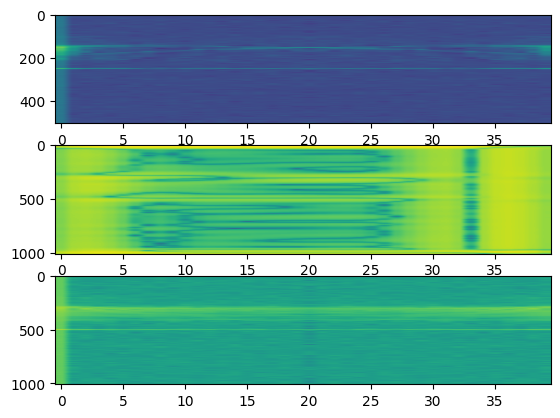

In [ ]:
delta=10e-6
"""
plot1 = (outputs[0,:,:,:].cpu().detach()+delta).permute(0,2,1)
plot2 = (targets[0,:,:,:].cpu().detach()+delta).permute(0,2,1)
plot3 = (inputs[0,:,:,:].cpu().detach()+delta).permute(0,2,1)
"""
plot1 = (outputs[0,:,:,:]).permute(0,1,2)
plot2 = (targets[0,:,:,:]).permute(0,1,2)
plot3 = (inputs[0,:,:,:]).permute(0,1,2)

i=0

plt.subplot(3,1,2)
#plt.imshow(10*np.log10(torch.abs(plot1[0,0]).permute(1,0)))
plt.imshow(20*np.log(np.abs(plot1[i])), aspect='auto')
plt.subplot(3,1,3)
plt.imshow(10*np.abs(plot2[i]), aspect='auto')
plt.subplot(3,1,1)
plt.imshow(plot3[i]**2, aspect='auto')
plt.show()

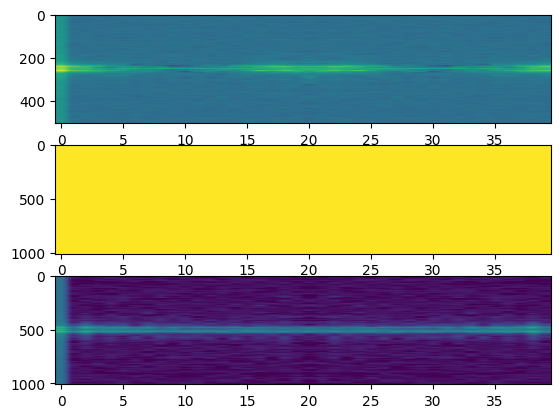

0.78557587 -4.8289647
151.05305 27.604225
0.0 -83.257256


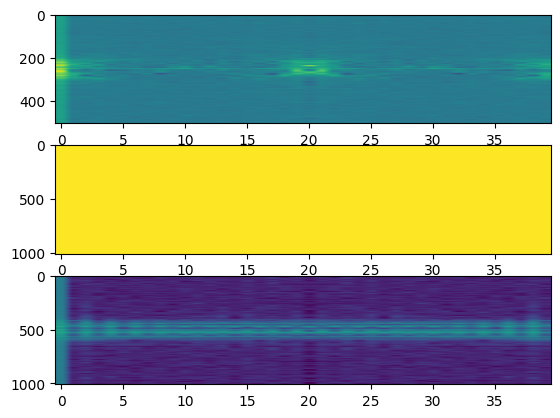

1.3862929 -6.336799
151.05305 27.604225
-5.177194e-07 -81.03046


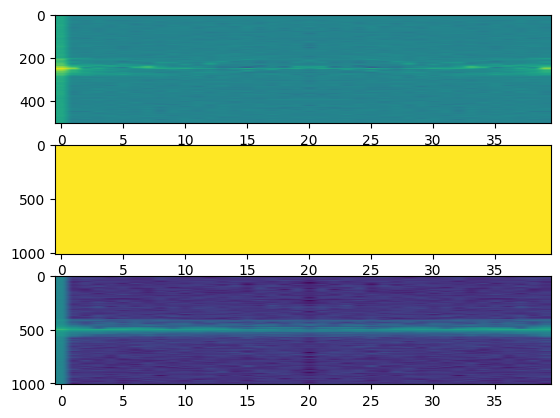

1.5086187 -8.500554
151.05305 27.604225
1.0354387e-06 -80.0397


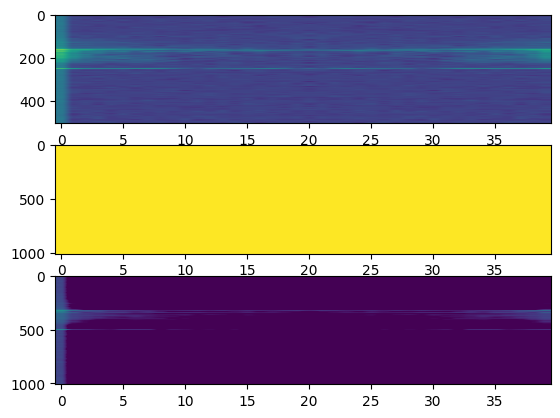

0.8375882 -3.8267221
151.05305 27.604225
0.0 -81.707985


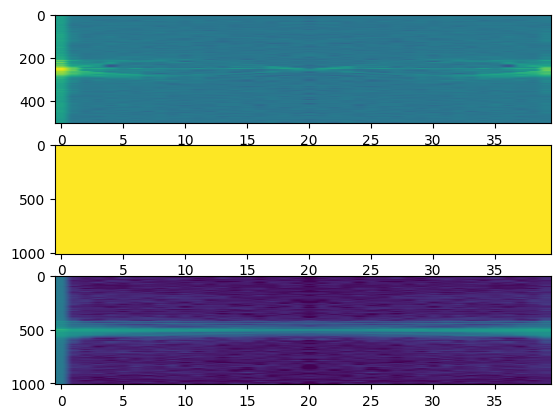

1.4046538 -7.1999693
151.05305 27.604225
1.0354387e-06 -79.89082


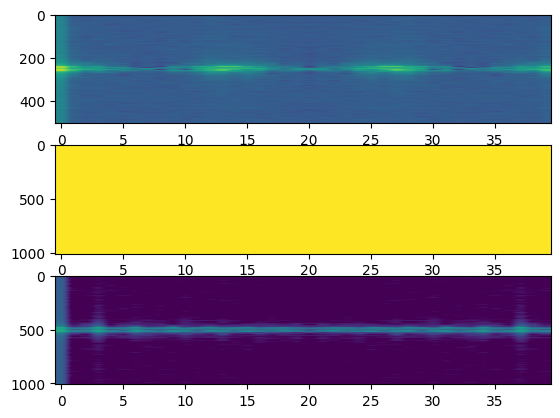

1.2270976 -4.08099
151.05305 27.604225
0.0 -83.03651


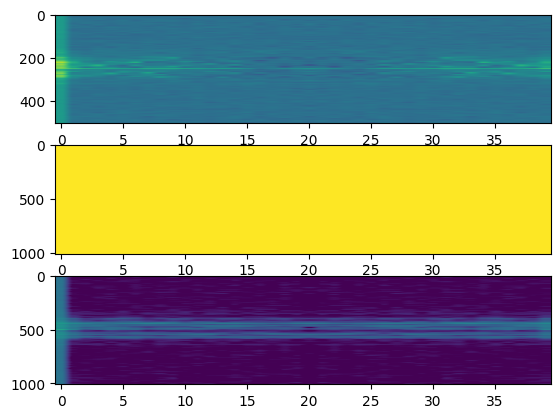

0.67523295 -5.3668327
151.05305 27.604225
0.0 -81.80786


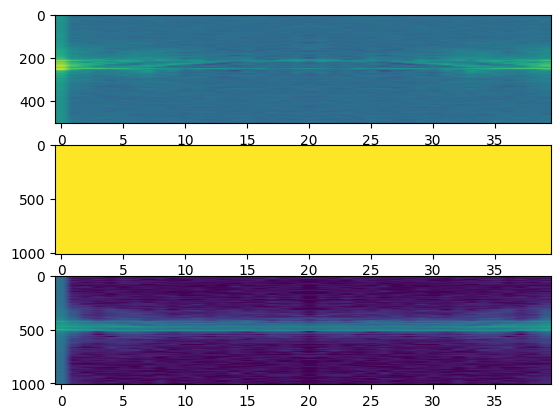

0.79917103 -6.39112
151.05305 27.604225
0.0 -81.86714


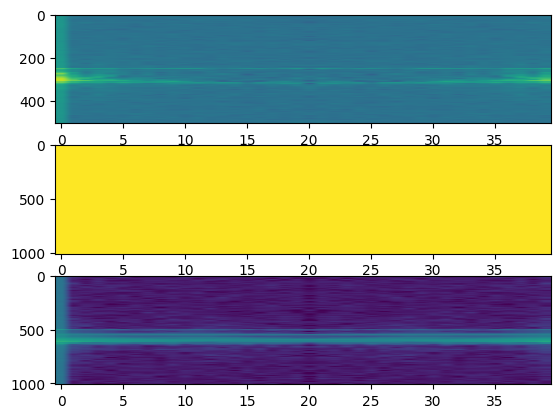

1.598596 -8.097731
151.05305 27.604225
0.0 -79.99814


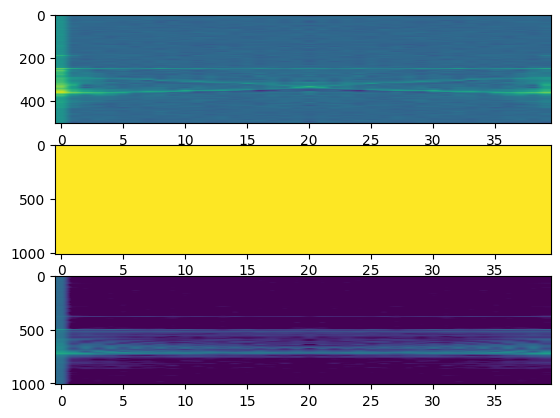

1.0490264 -5.0190916
151.05305 27.604225
0.0 -81.31416


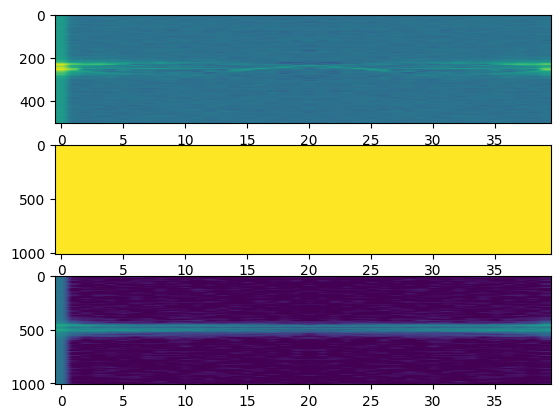

1.4592868 -5.985757
151.05305 27.604225
0.0 -79.846146


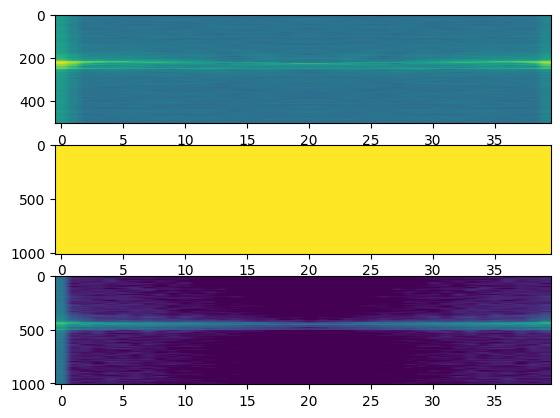

1.0145586 -5.889735
151.05305 27.604225
0.0 -81.12314


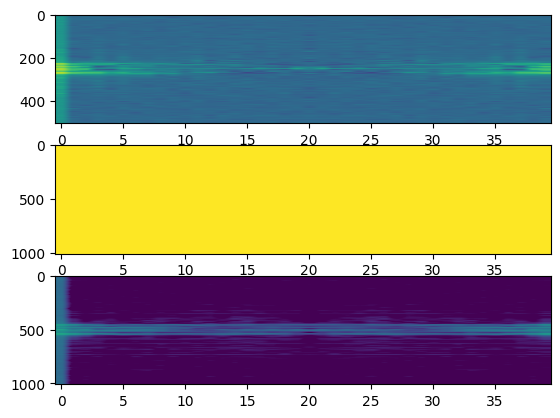

1.1570837 -5.832016
151.05305 27.604225
0.0 -80.10672


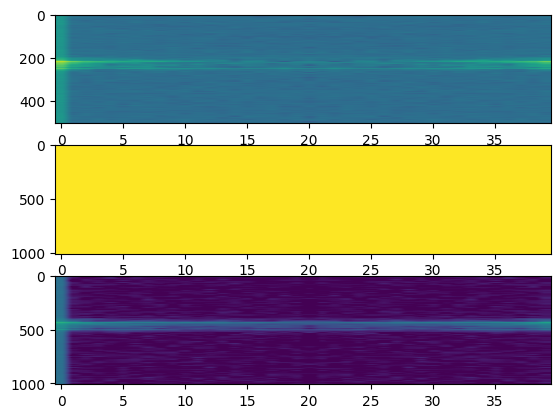

1.3344009 -5.2627845
151.05305 27.604225
0.0 -81.24191


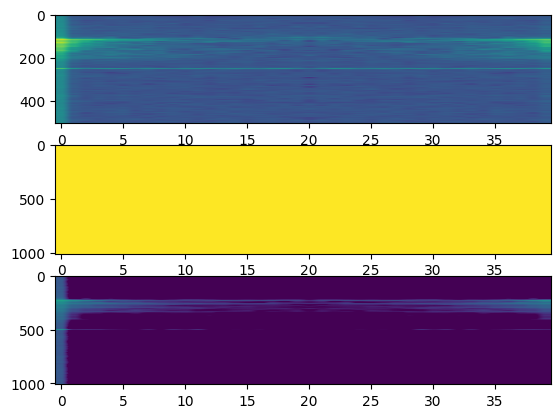

0.6694284 -3.243365
151.05305 27.604225
0.0 -82.61835


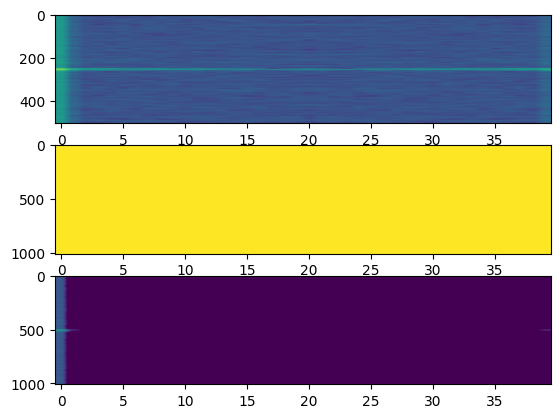

0.71594304 -3.3704875
151.05305 27.604225
0.0 -79.922585


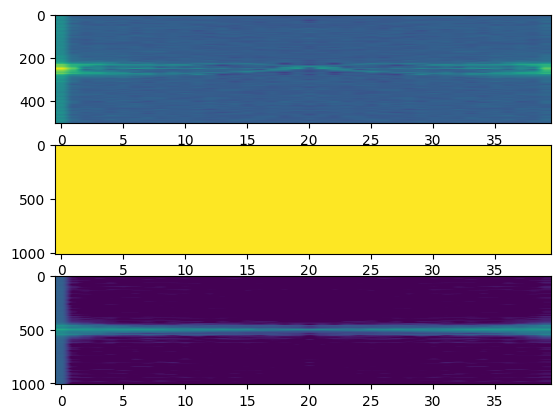

1.6215756 -6.681512
151.05305 27.604225
1.0354387e-06 -79.45361


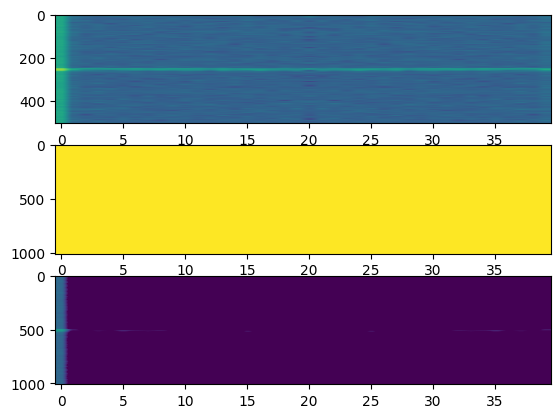

0.4543718 -2.7341616
151.05305 27.604225
0.0 -82.20566


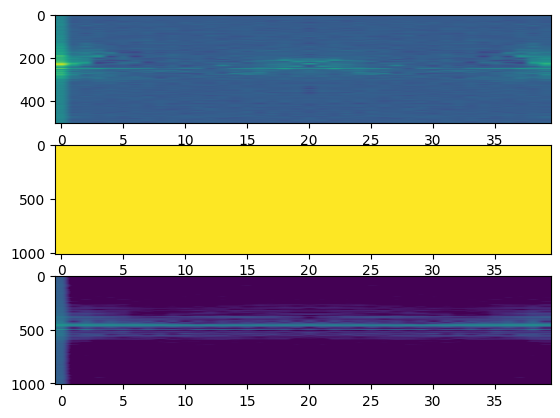

1.1431981 -4.090193
151.05305 27.604225
0.0 -82.53288


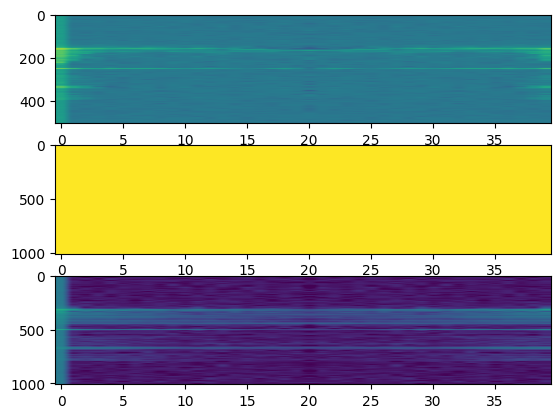

0.83721393 -6.540916
151.05305 27.604225
0.0 -81.38528


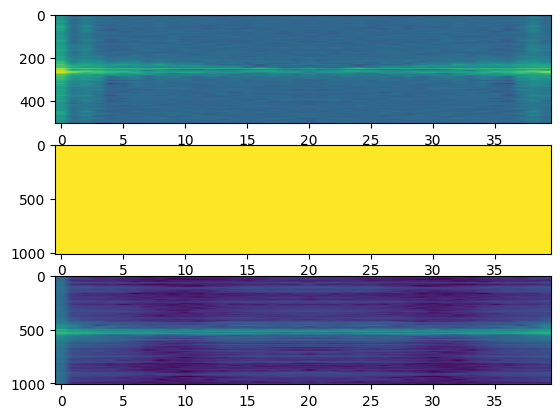

0.76883245 -8.544284
151.05305 27.604225
1.0354387e-06 -81.33078


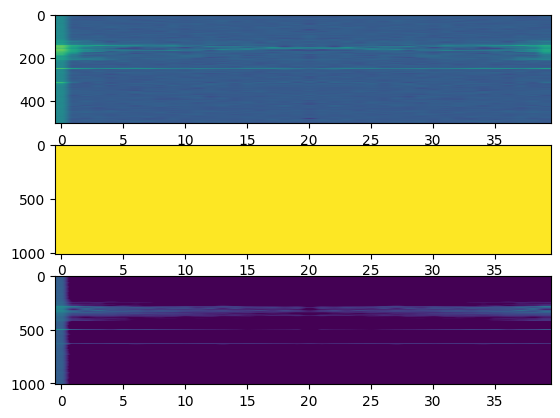

0.86827826 -5.0011797
151.05305 27.604225
0.0 -81.124435


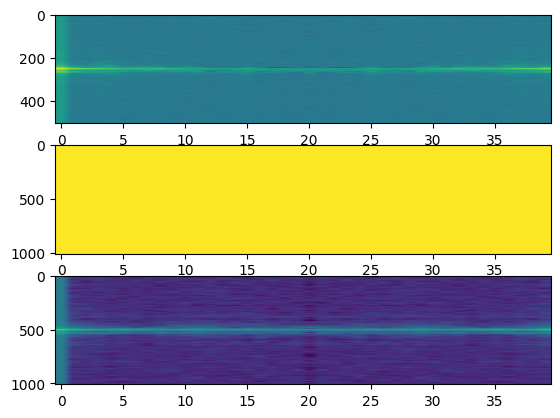

1.1473819 -8.3584795
151.05305 27.604225
0.0 -81.28087


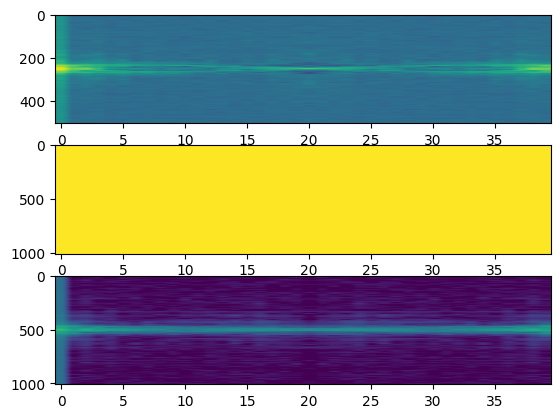

1.2377006 -5.4198527
151.05305 27.604225
0.0 -81.47249


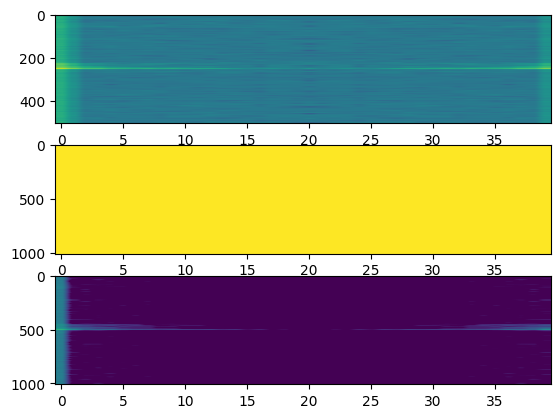

0.59030193 -3.8909457
151.05305 27.604225
0.0 -81.27732


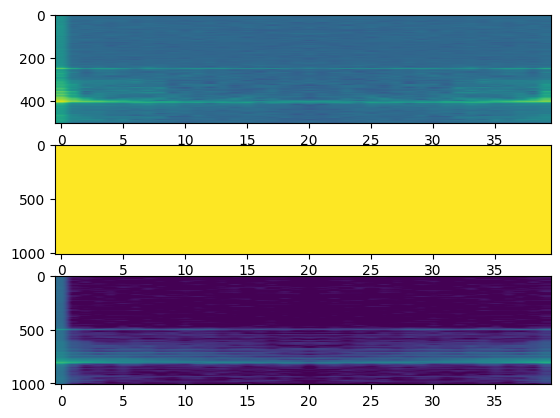

1.2991787 -5.675685
151.05305 27.604225
0.0 -80.93042


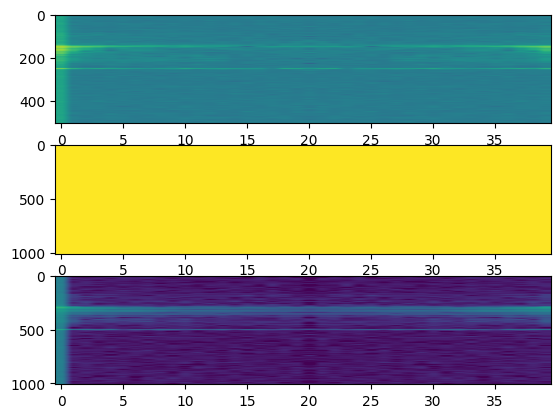

0.87799454 -6.263079
151.05305 27.604225
-5.177194e-07 -81.029144


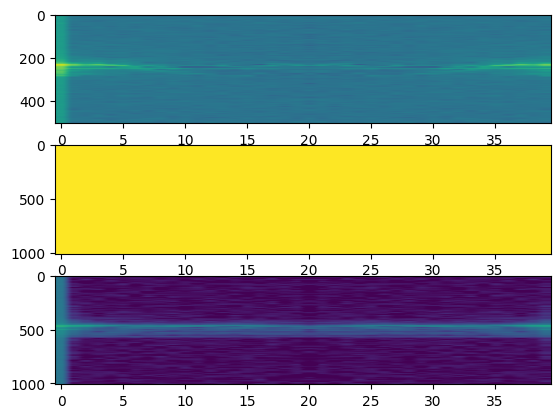

1.266963 -5.166523
151.05305 27.604225
0.0 -81.33167


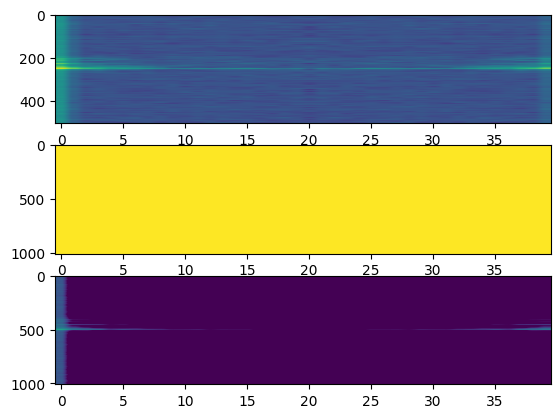

0.7188623 -3.013203
151.05305 27.604225
-5.177194e-07 -81.24084


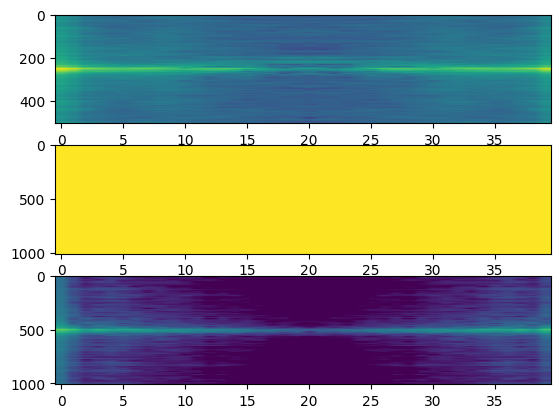

1.0200504 -6.854829
151.05305 27.604225
0.0 -81.643875


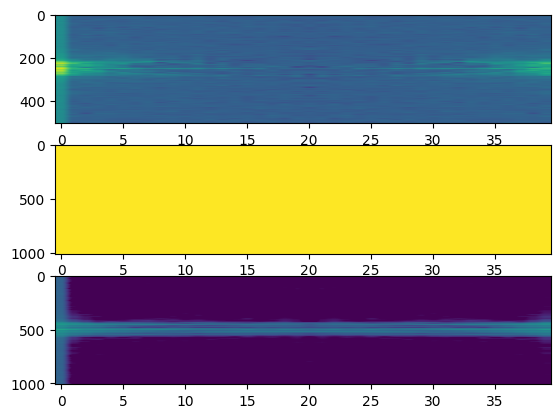

1.267108 -5.75691
151.05305 27.604225
0.0 -80.22177


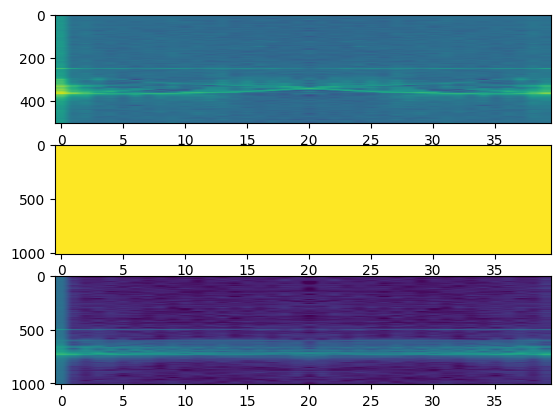

1.5978725 -6.84335
151.05305 27.604225
0.0 -80.667915


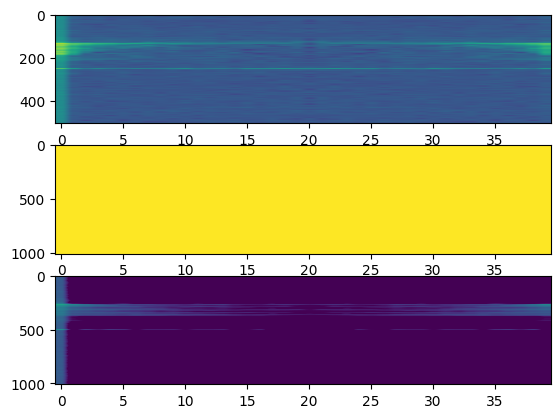

0.82394093 -4.127576
151.05305 27.604225
0.0 -80.72326


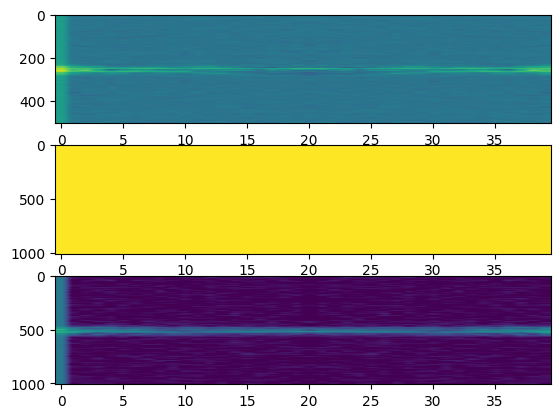

0.6988192 -6.1595893
151.05305 27.604225
0.0 -81.04306


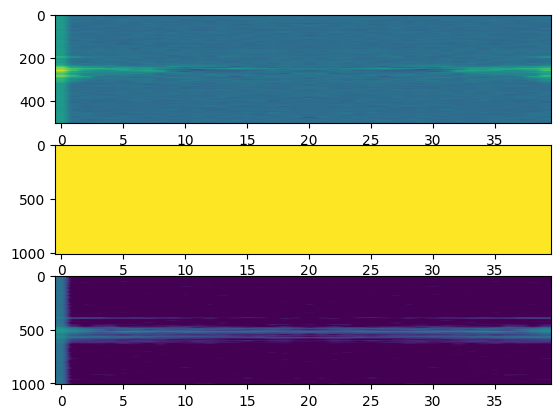

1.0462703 -3.715615
151.05305 27.604225
0.0 -82.34832


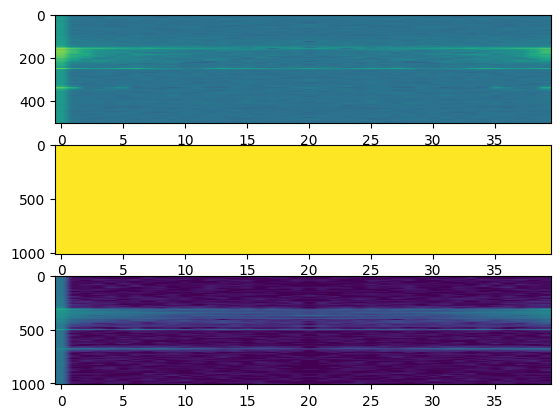

1.010538 -5.6035132
151.05305 27.604225
0.0 -81.46849


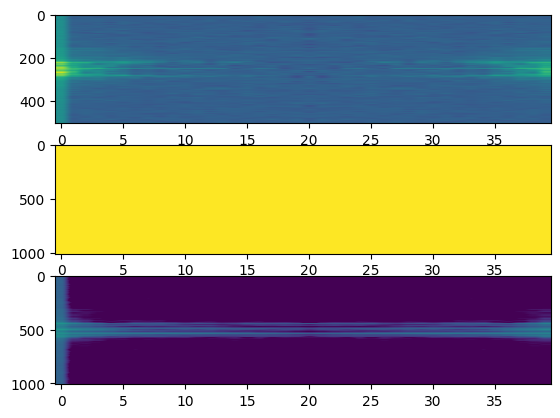

1.113231 -4.3431435
151.05305 27.604225
0.0 -81.054695


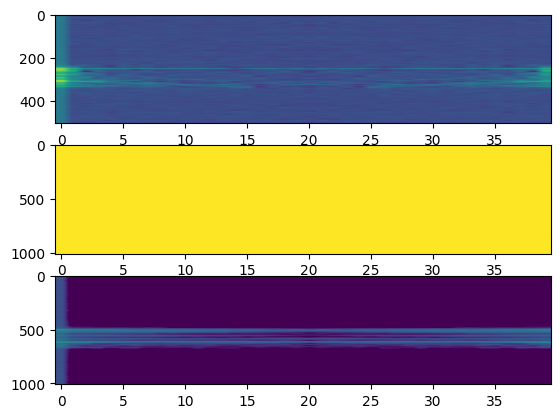

1.3551292 -4.114854
151.05305 27.604225
0.0 -81.857956


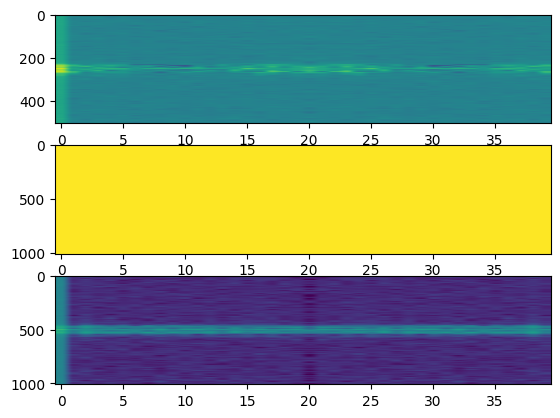

1.2642117 -7.7268333
151.05305 27.604225
-5.177194e-07 -80.37151


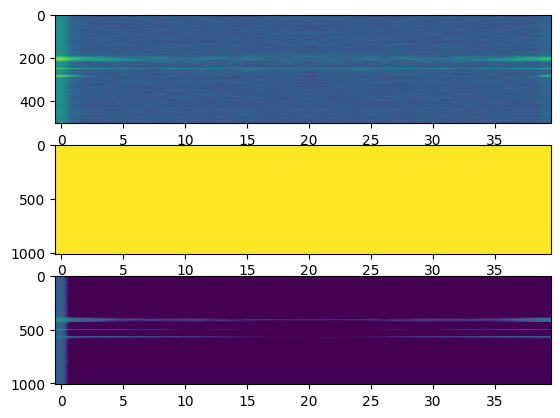

0.93822217 -3.9795196
151.05305 27.604225
0.0 -80.970116


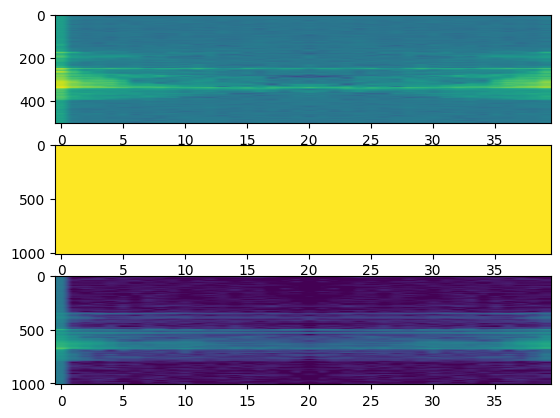

0.80968744 -5.2649555
151.05305 27.604225
0.0 -81.89991


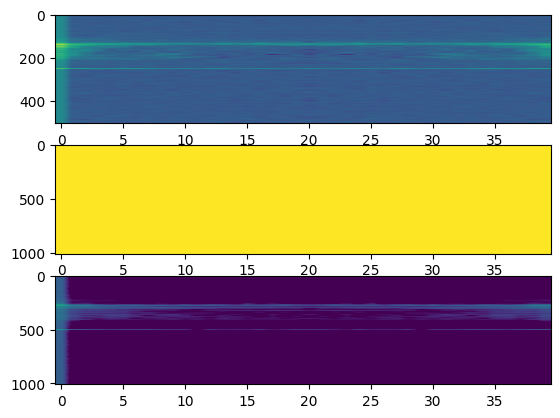

0.853112 -4.765133
151.05305 27.604225
0.0 -81.47853


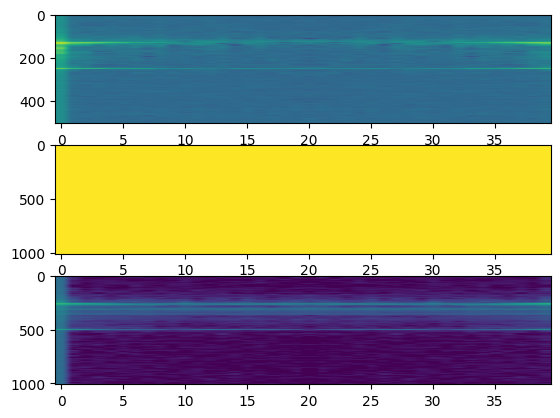

0.88973856 -6.3582764
151.05305 27.604225
0.0 -81.81096


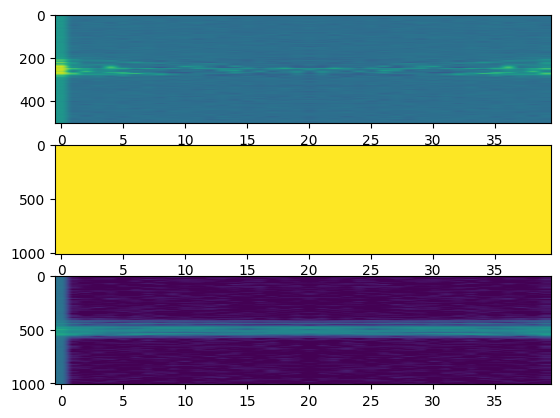

0.94301575 -4.9919457
151.05305 27.604225
0.0 -82.24005


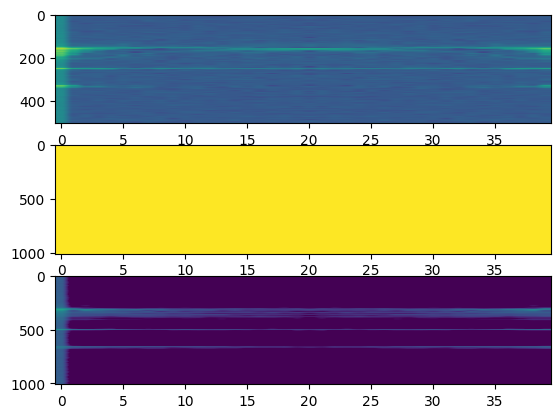

1.0166072 -4.595955
151.05305 27.604225
0.0 -80.94832


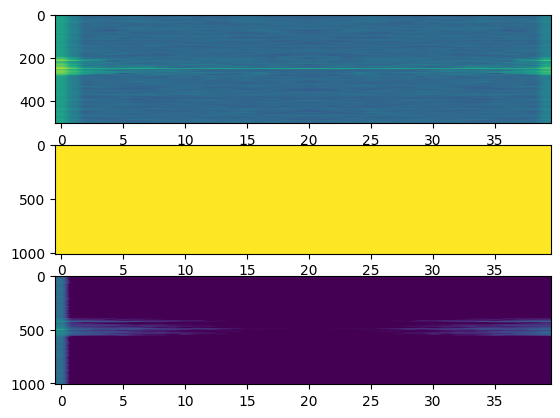

0.1557825 -4.485475
151.05305 27.604225
0.0 -81.28641


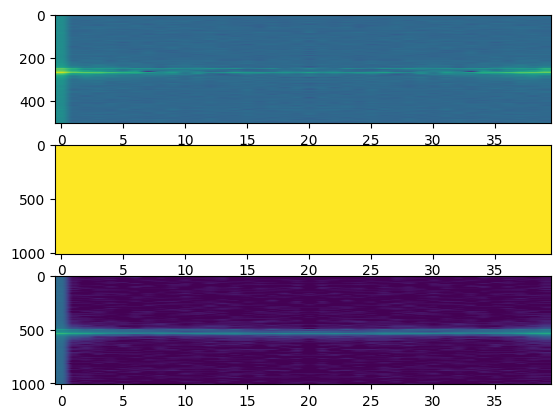

1.251133 -7.0068874
151.05305 27.604225
0.0 -80.63605


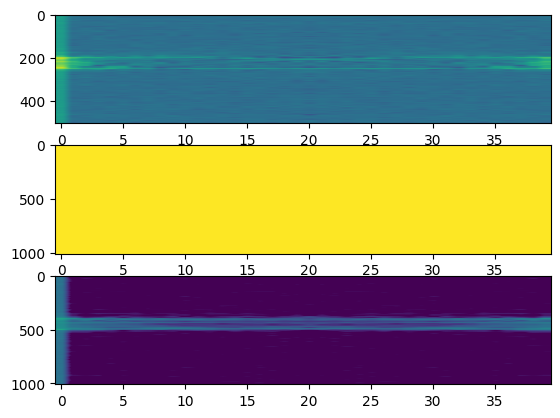

0.72028244 -4.6958165
151.05305 27.604225
0.0 -81.69669


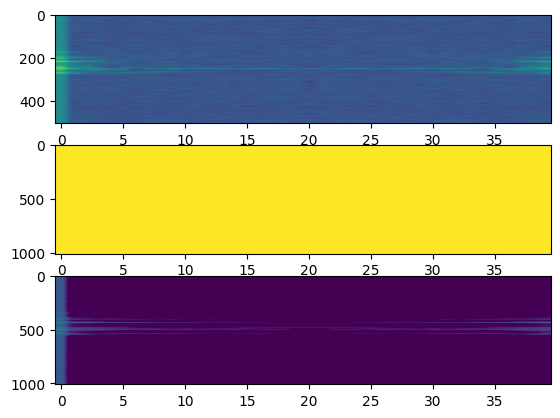

1.1152455 -3.6779904
151.05305 27.604225
-5.177194e-07 -80.5917


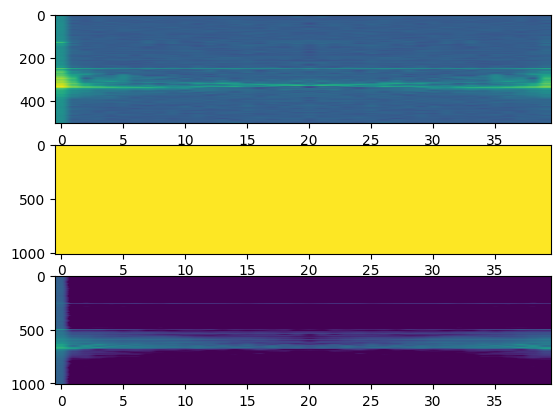

0.8813555 -4.6315603
151.05305 27.604225
0.0 -81.1919


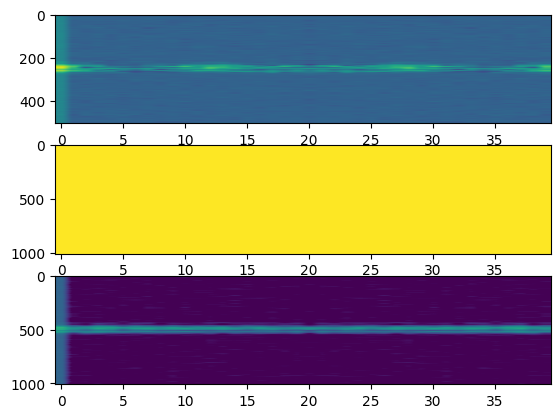

1.1690133 -6.014211
151.05305 27.604225
0.0 -81.49659


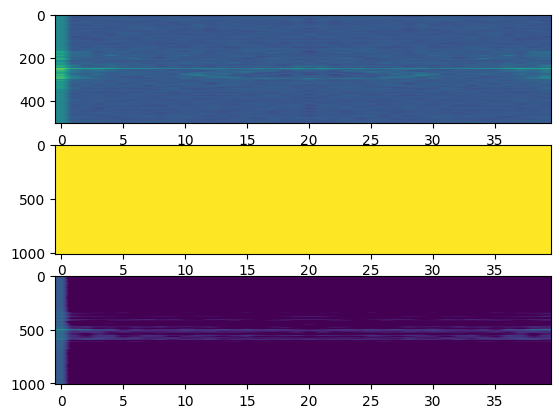

0.7779438 -5.5179586
151.05305 27.604225
0.0 -80.257965


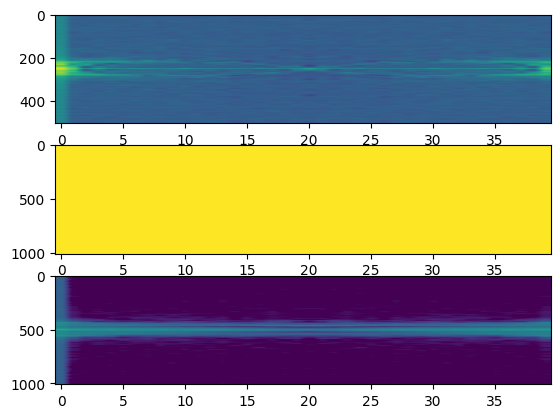

1.3897831 -6.288502
151.05305 27.604225
0.0 -80.31276


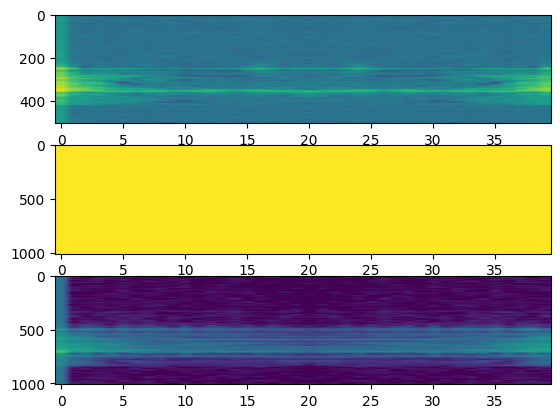

1.0591311 -6.805468
151.05305 27.604225
0.0 -80.3369


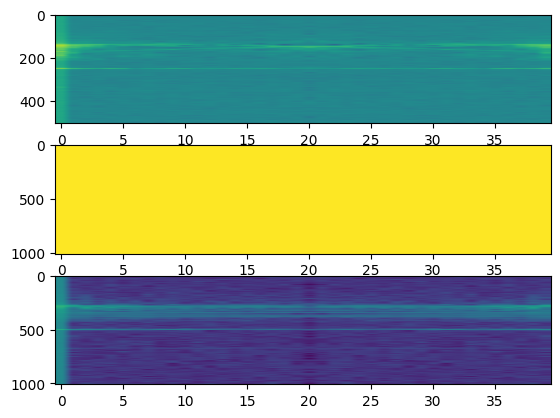

0.8623239 -6.794506
151.05305 27.604225
0.0 -82.09804


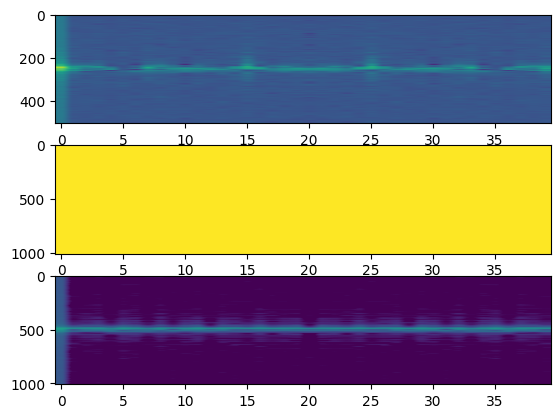

1.8484652 -5.253322
151.05305 27.604225
0.0 -81.49268


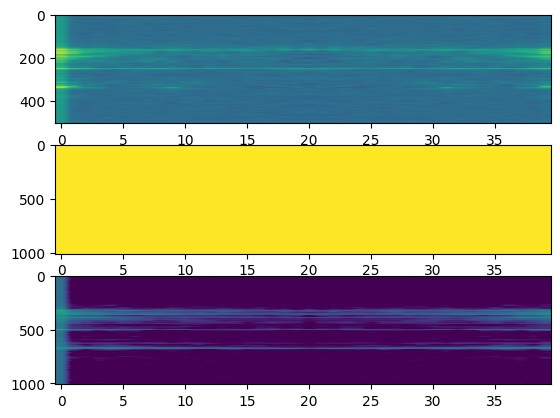

0.8842543 -5.6004934
151.05305 27.604225
0.0 -80.33362


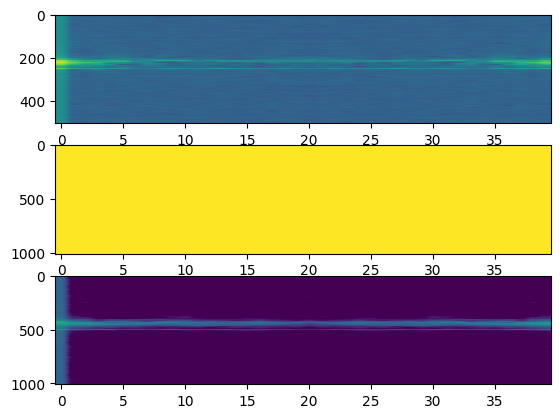

0.81673086 -5.1943684
151.05305 27.604225
0.0 -81.25786


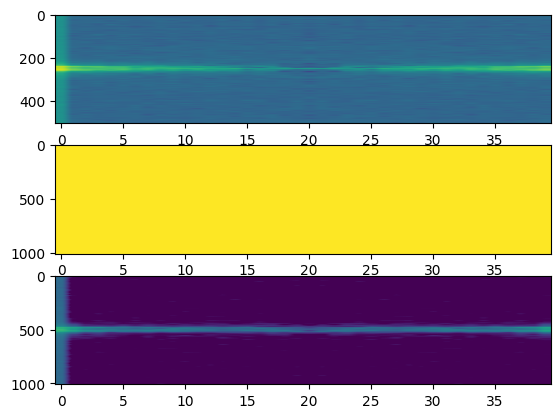

0.71447074 -5.436756
151.05305 27.604225
0.0 -81.499405


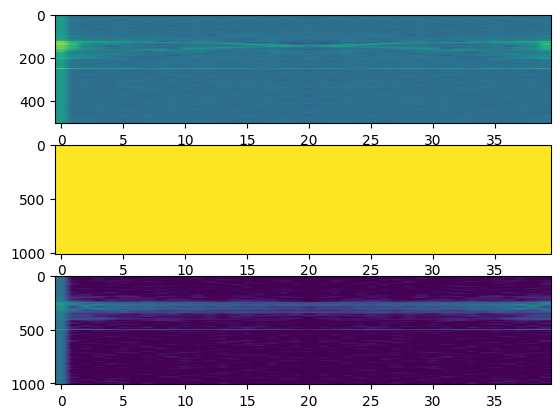

0.899302 -6.3200407
151.05305 27.604225
0.0 -80.698166


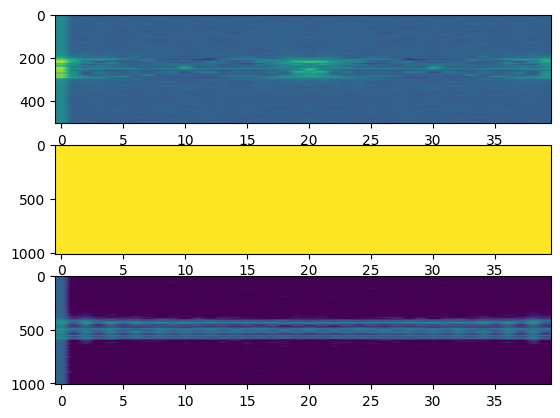

1.4119827 -5.2655625
151.05305 27.604225
0.0 -80.84777


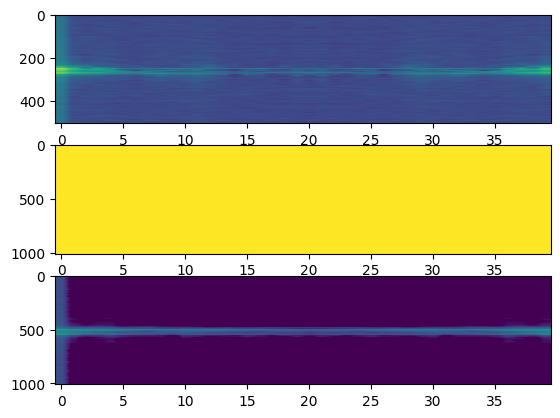

1.3411913 -4.334176
151.05305 27.604225
0.0 -82.281525


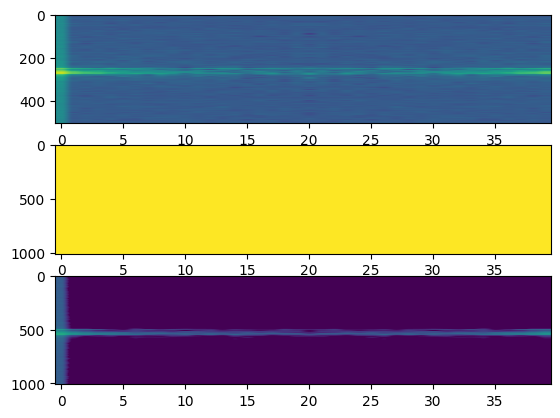

0.6064832 -3.7730274
151.05305 27.604225
0.0 -82.68337


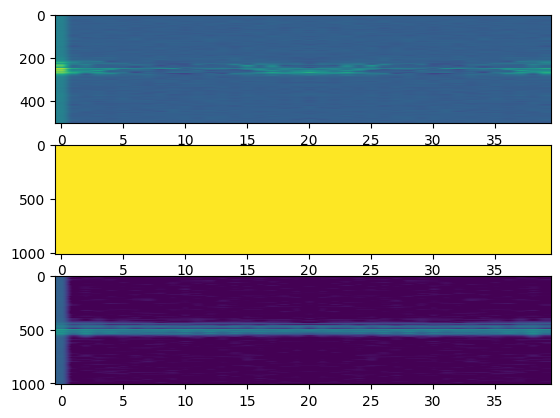

1.7891812 -7.3035975
151.05305 27.604225
-5.177194e-07 -80.236824


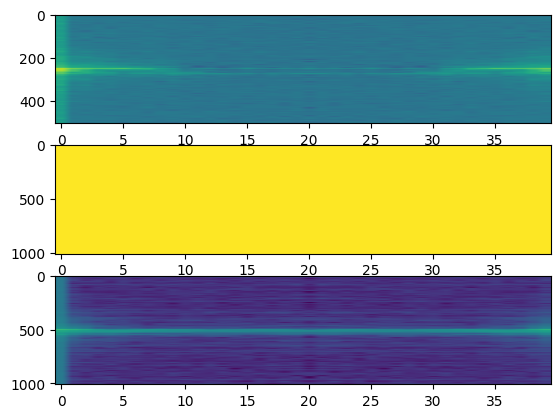

1.0057511 -7.7534714
151.05305 27.604225
0.0 -81.57466


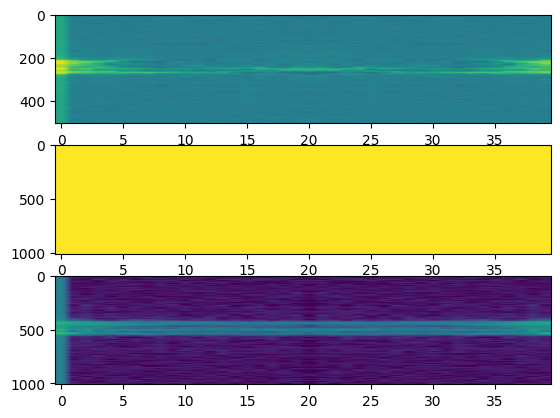

0.936709 -5.9634094
151.05305 27.604225
0.0 -80.797424


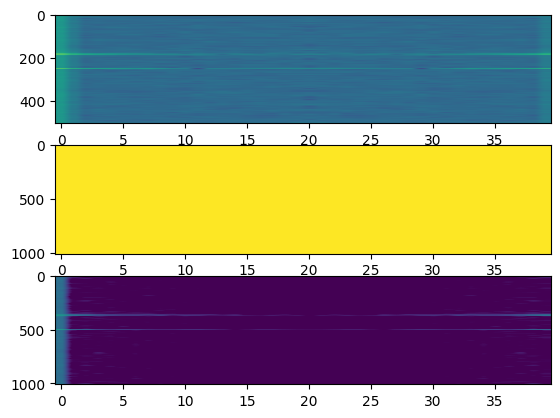

0.6962603 -4.424414
151.05305 27.604225
0.0 -82.06857


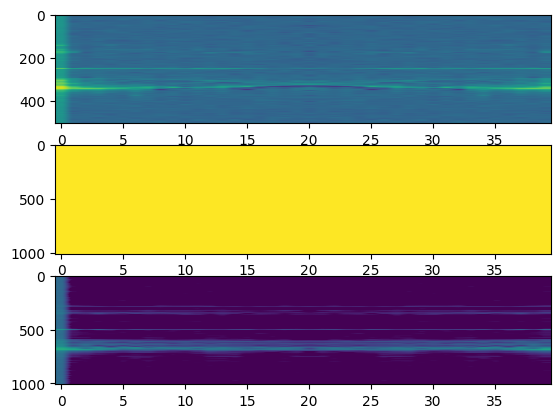

1.0140499 -5.569208
151.05305 27.604225
0.0 -80.47987


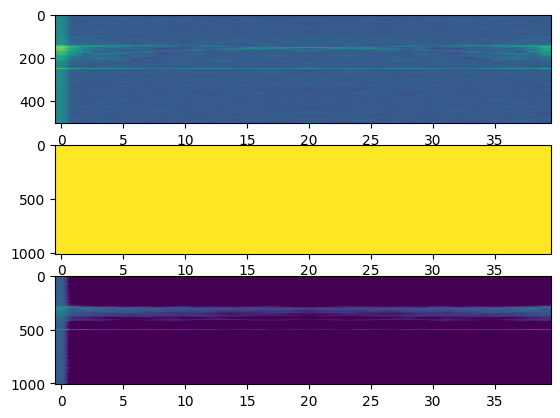

0.8515482 -4.1553283
151.05305 27.604225
0.0 -82.21729


In [ ]:
up = nn.Upsample(scale_factor = 1, mode='bilinear')

with torch.no_grad():
        test_loss = 0.0
        i = 0
        for inputs, targets in test_loader:
            #if i == 19:
            inputs = inputs
            targets = targets

            #outputs = unet(inputs)
            data_max = np.max(np.abs(inputs.cpu().detach().numpy()[0,0]))
            data_min = np.min(np.abs(inputs.cpu().detach().numpy()[0,0]))

            plt.subplot(3,1,1)
            plt.imshow(np.abs(up(inputs).cpu().detach().numpy()[0,0]), vmax = data_max, vmin = data_min, aspect='auto')
            plt.subplot(3,1,2)
            plt.imshow(np.abs(outputs.cpu().detach().numpy()[0,0]), vmax = data_max, vmin = data_min, aspect='auto')
            plt.subplot(3,1,3)
            plt.imshow(np.abs(targets.cpu().detach().numpy()[0,0]), vmax = data_max, vmin = data_min, aspect='auto')
            plt.show()
            print(np.max(20*np.log10(np.abs(inputs.cpu().detach().numpy()[0,0]))),np.min(20*np.log10(np.abs(inputs.cpu().detach().numpy()[0,0]))))
            print(np.max(20*np.log10(np.abs(outputs.cpu().detach().numpy()[0,0]))),np.min(20*np.log10(np.abs(outputs.cpu().detach().numpy()[0,0]))))
            print(np.max(20*np.log10(np.abs(targets.cpu().detach().numpy()[0,0]))),np.min(20*np.log10(np.abs(targets.cpu().detach().numpy()[0,0]))))
            #print(l2loss(np.abs(outputs.cpu()),np.abs(targets.cpu())))

In [ ]:
plot1.shape

torch.Size([32, 200, 1008])

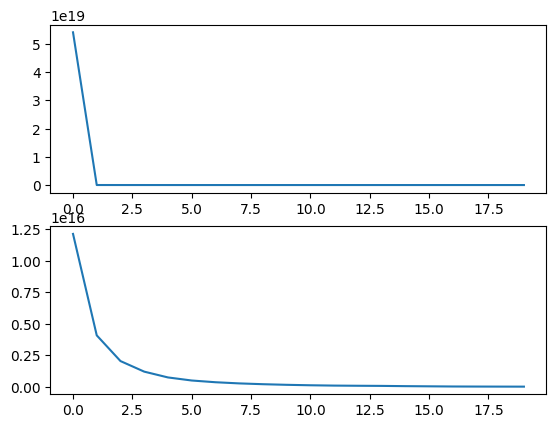

In [ ]:
plt.subplot(2,1,1)
plt.plot(loss_list[0])
plt.subplot(2,1,2)
plt.plot(loss_list[1])